<a href="https://colab.research.google.com/github/mrMichalR/blueberry_yield/blob/main/blueberry_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Blueberry yield prediction**

In [110]:
!pip install pandas_profiling
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [112]:
import pandas as pd
from tqdm import tqdm, trange
import numpy as np
from numpy import std, unique, mean
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import os, sys
import optuna
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from google.colab import files
from pandas import set_option
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, RFE, RFECV 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Perceptron


# Data load

In [3]:
url_train ='https://raw.githubusercontent.com/mrMichalR/blueberry_yield/main/data/train.csv'
url_test = 'https://raw.githubusercontent.com/mrMichalR/blueberry_yield/main/data/test.csv'
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_train

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,15284,12.5,0.25,0.25,0.38,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.556302,0.476308,40.546480,7667.83619
15285,15285,12.5,0.25,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.354413,0.388145,29.467434,3680.56025
15286,15286,25.0,0.50,0.25,0.38,0.75,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.422548,0.416786,32.299059,4696.44394
15287,15287,25.0,0.50,0.25,0.63,0.63,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.542170,0.434133,36.674243,6772.93347


In [4]:
df_train['type'] = 'train'
df_test['type'] = 'test'

df_ = pd.concat([df_train, df_test])
df_ = df_.reset_index(drop=True)

df_

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,type
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146,train
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201,train
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760,train
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590,train
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25478,25478,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.474162,0.437923,34.525258,NaN,test
25479,25479,25.0,0.50,0.25,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.482854,0.440676,35.648221,NaN,test
25480,25480,25.0,0.50,0.38,0.50,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.568854,0.463065,37.724724,NaN,test
25481,25481,12.5,0.25,0.25,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.407374,0.409261,31.881847,NaN,test


# EDA

## Pandas profiling

In [5]:
# description = "Disclaimer: this profiling report was generated using minimal mode"

# for number, elem in zip(range(1,4), df_list):
#   prof = elem.profile_report(dataset={"description": description}, minimal=True)
#   prof.to_notebook_iframe()
#   prof.to_file(output_file=f'ProfileReport{number}.html')

Descriptive analysis

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10194 non-null  int64  
 1   clonesize             10194 non-null  float64
 2   honeybee              10194 non-null  float64
 3   bumbles               10194 non-null  float64
 4   andrena               10194 non-null  float64
 5   osmia                 10194 non-null  float64
 6   MaxOfUpperTRange      10194 non-null  float64
 7   MinOfUpperTRange      10194 non-null  float64
 8   AverageOfUpperTRange  10194 non-null  float64
 9   MaxOfLowerTRange      10194 non-null  float64
 10  MinOfLowerTRange      10194 non-null  float64
 11  AverageOfLowerTRange  10194 non-null  float64
 12  RainingDays           10194 non-null  float64
 13  AverageRainingDays    10194 non-null  float64
 14  fruitset              10194 non-null  float64
 15  fruitmass          

In [8]:
df_train.describe(include='all')

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,type
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15289
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999,NaN
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850,NaN
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610,NaN
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510,NaN
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900,NaN
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380,NaN


In [9]:
df_train.nunique()

id                      15289
clonesize                   6
honeybee                    7
bumbles                    11
andrena                    16
osmia                      14
MaxOfUpperTRange            6
MinOfUpperTRange            5
AverageOfUpperTRange        5
MaxOfLowerTRange            6
MinOfLowerTRange            7
AverageOfLowerTRange        5
RainingDays                 6
AverageRainingDays          8
fruitset                 1526
fruitmass                1515
seeds                    2066
yield                     776
type                        1
dtype: int64

In [10]:
df_train.isnull().any()

id                      False
clonesize               False
honeybee                False
bumbles                 False
andrena                 False
osmia                   False
MaxOfUpperTRange        False
MinOfUpperTRange        False
AverageOfUpperTRange    False
MaxOfLowerTRange        False
MinOfLowerTRange        False
AverageOfLowerTRange    False
RainingDays             False
AverageRainingDays      False
fruitset                False
fruitmass               False
seeds                   False
yield                   False
type                    False
dtype: bool

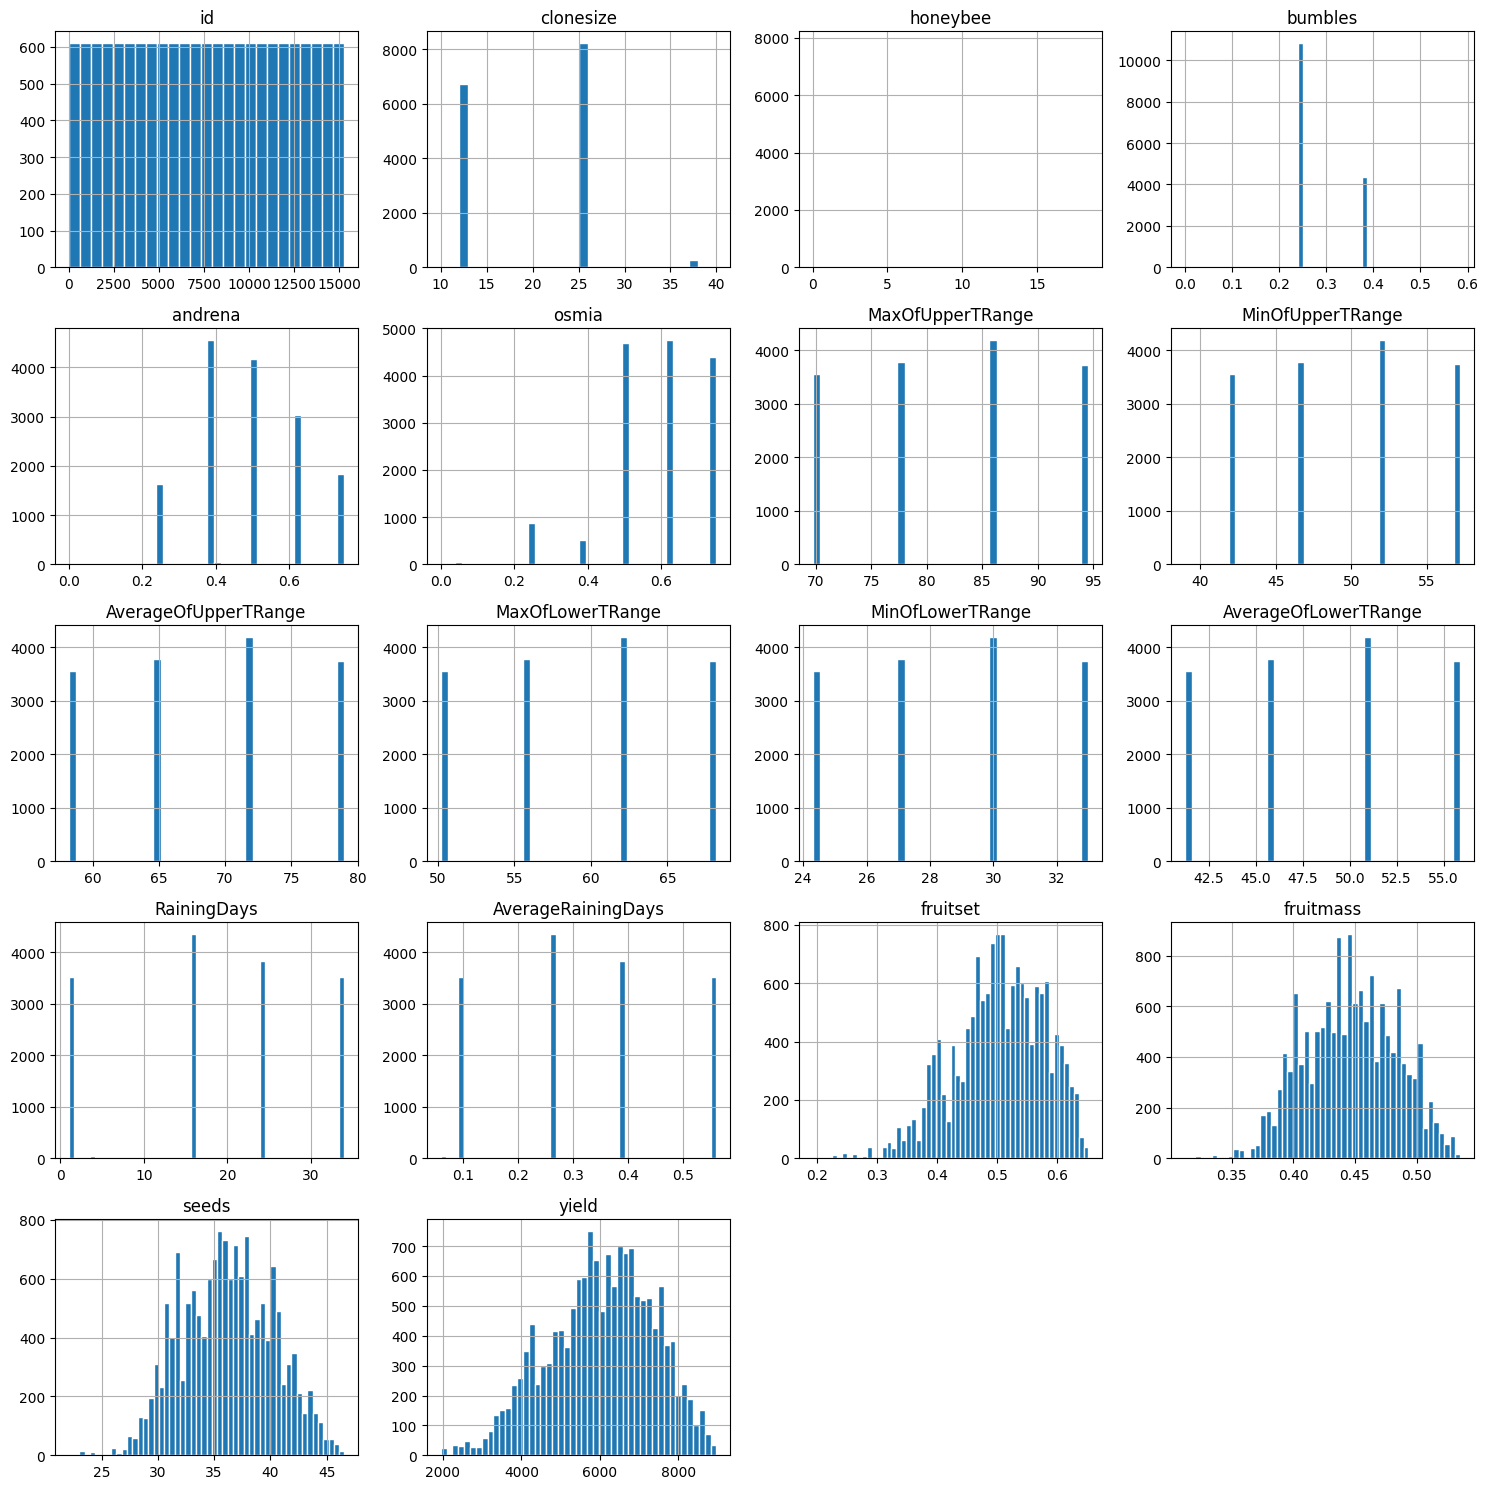

In [11]:
# histograms of each attribute to get a sense of the data distributions
df_train.hist(figsize=(15,15), sharex=False, sharey=False, bins='auto', ec="white")
plt.tight_layout()
plt.show()

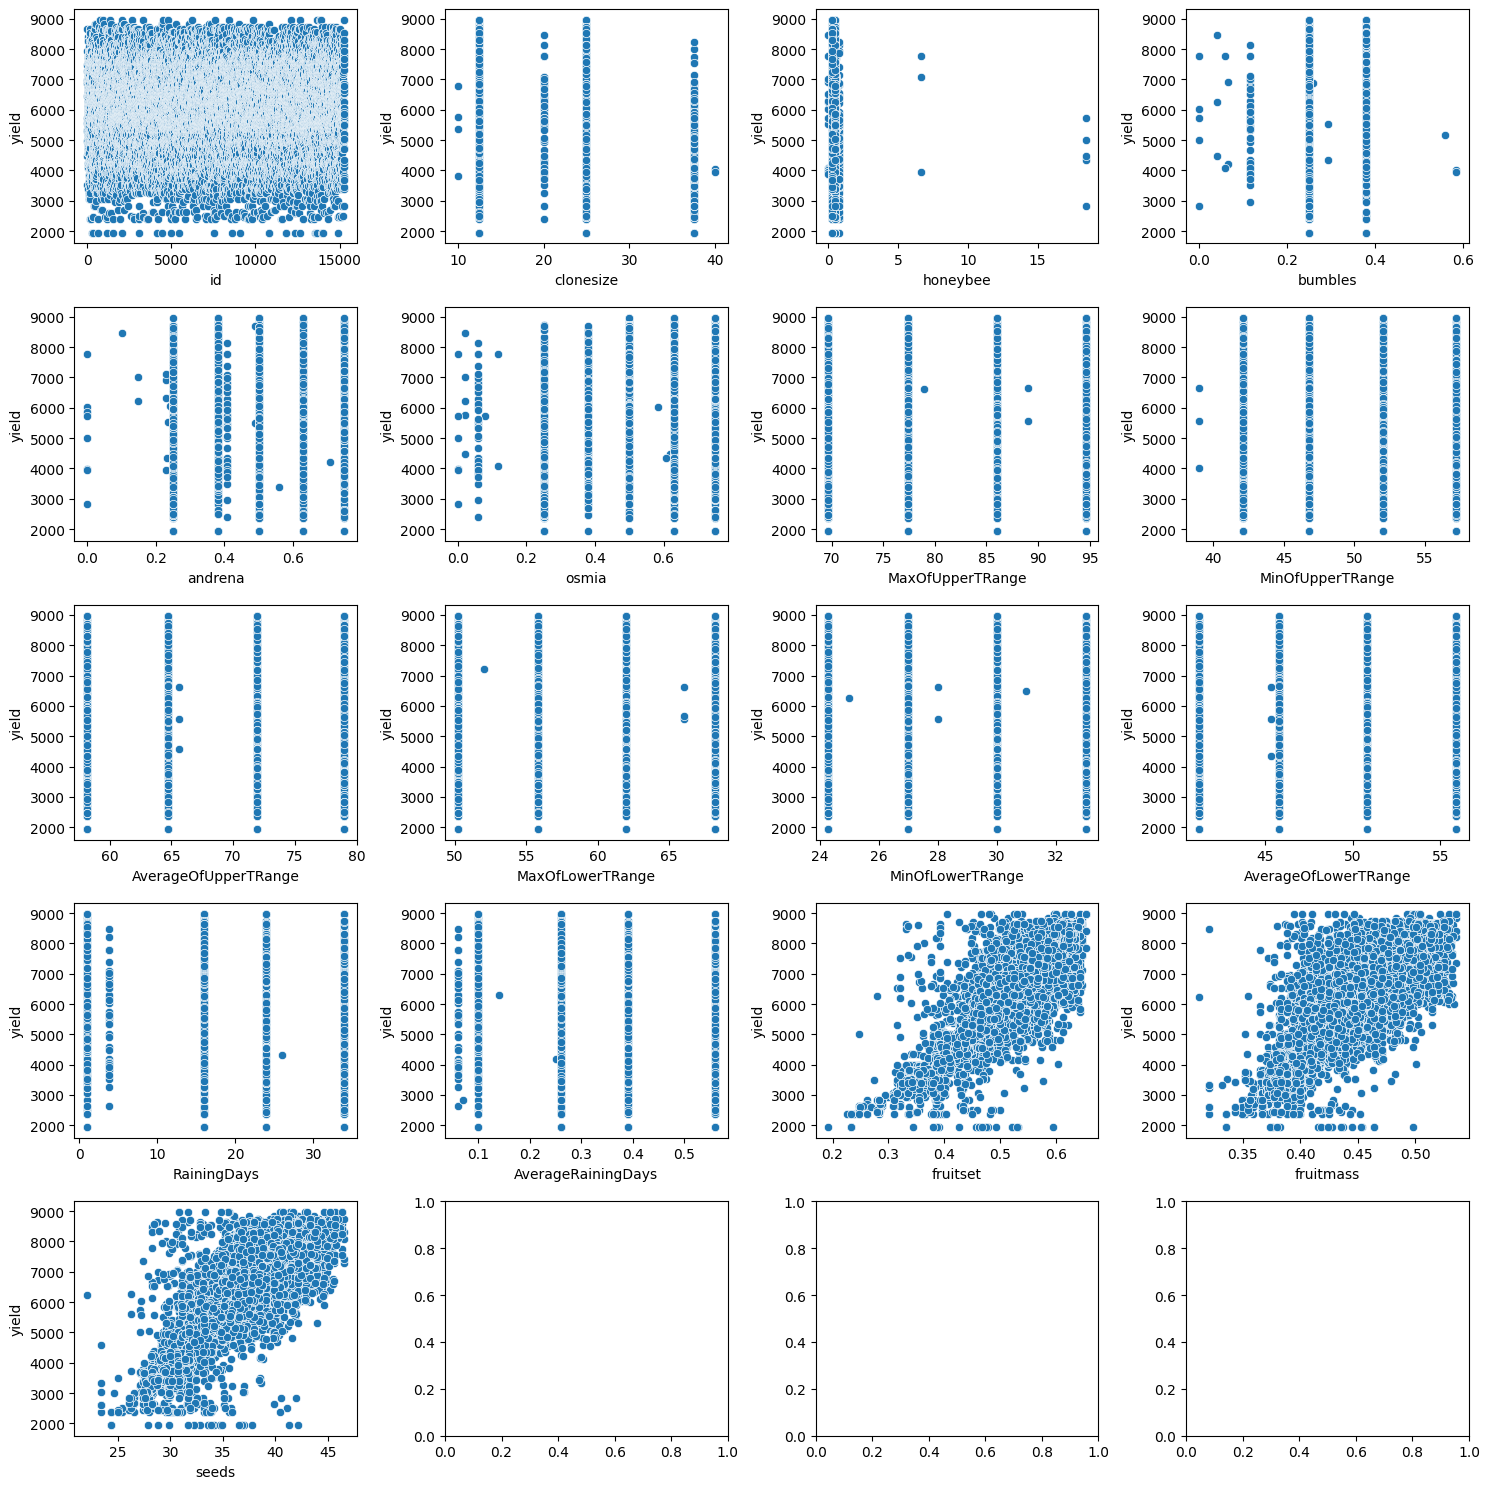

In [12]:
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))
index = 0
axs = axs.flatten()
for k,v in df_train.iloc[:,0:17].items():
  sns.scatterplot(data=df_train, x=v, y='yield', legend='auto', ax=axs[index])
  index +=1
plt.tight_layout()

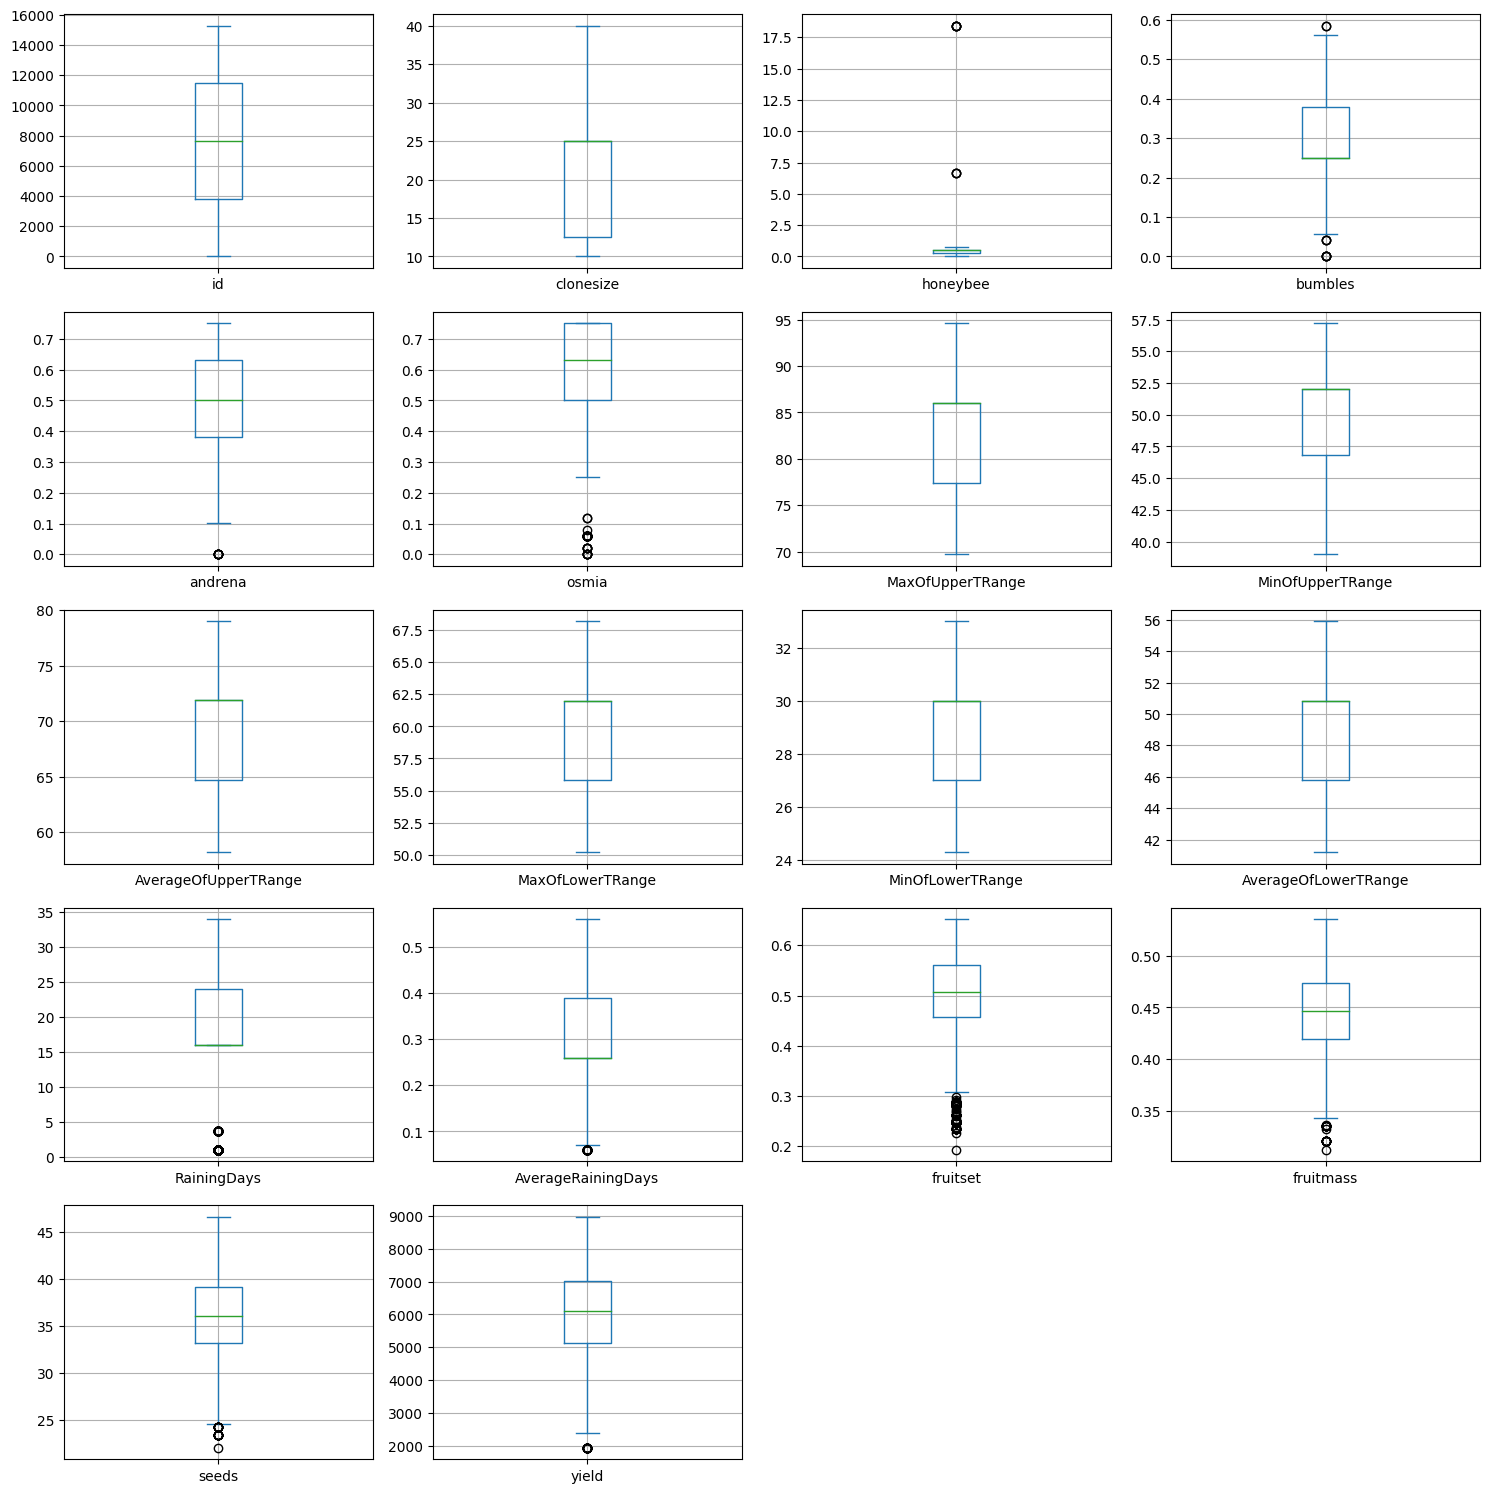

In [13]:
# box and whisker plots
df_train.plot(kind='box', figsize=(15,15), subplots=True, layout=(5,4), sharex=False, sharey=False, grid=True)
plt.tight_layout()

<ipython-input-14-10087cdad1b6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(method='pearson'), annot=True, fmt='.3f')


<Axes: >

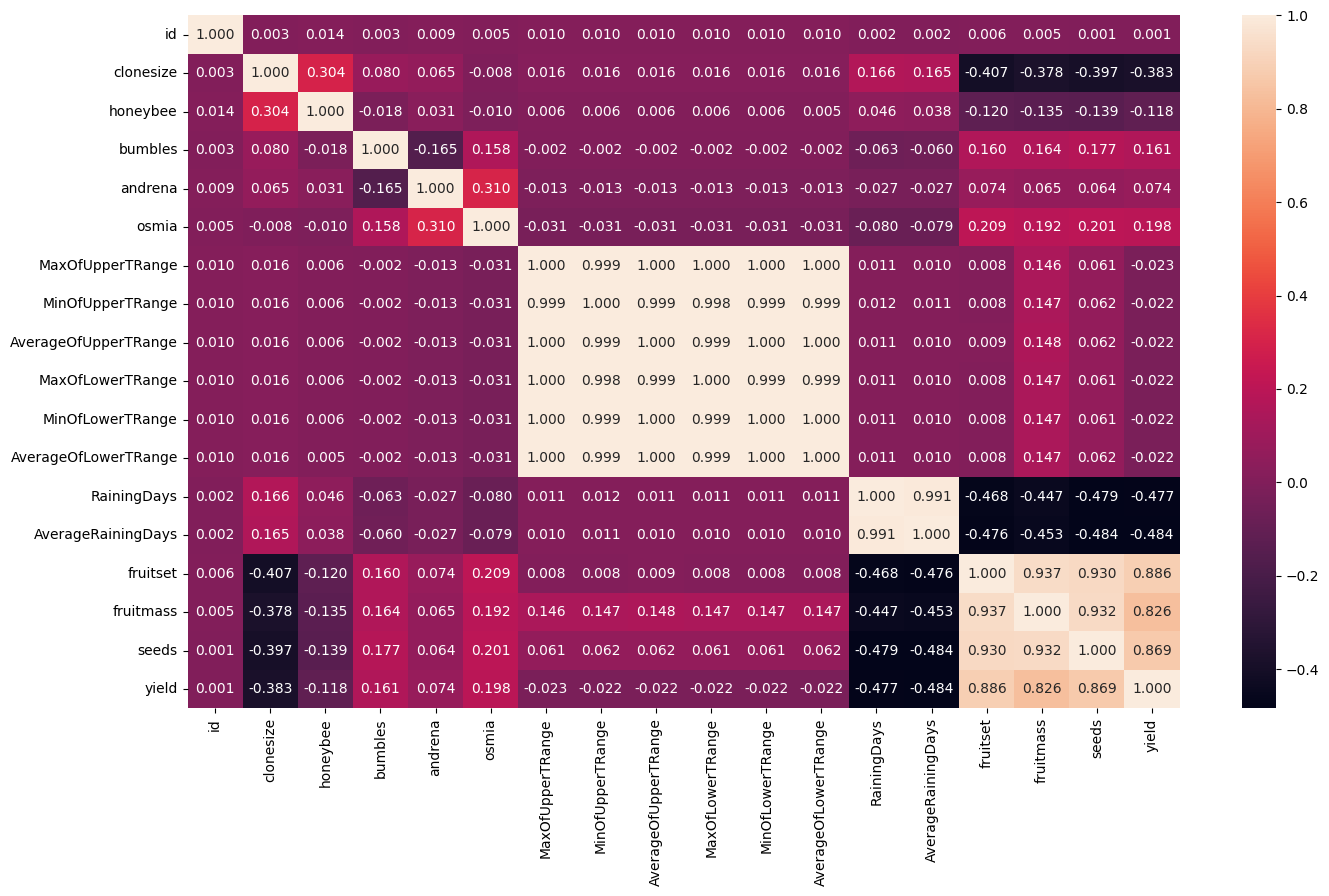

In [14]:
plt.rcParams["figure.figsize"] = [16,9]
sns.heatmap(df_train.corr(method='pearson'), annot=True, fmt='.3f')

In [15]:
cor = df_train.corr(method='pearson').abs().unstack()
cor_sort = cor.sort_values(kind="quicksort", ascending=False)
print(cor_sort['yield'])

yield                   1.000000
fruitset                0.885967
seeds                   0.868853
fruitmass               0.826481
AverageRainingDays      0.483870
RainingDays             0.477191
clonesize               0.382619
osmia                   0.198264
bumbles                 0.161145
honeybee                0.118001
andrena                 0.073969
MaxOfUpperTRange        0.022517
MinOfLowerTRange        0.022319
MaxOfLowerTRange        0.022197
AverageOfLowerTRange    0.022081
AverageOfUpperTRange    0.021940
MinOfUpperTRange        0.021929
id                      0.000975
dtype: float64


<ipython-input-15-27ba987ba7b1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_train.corr(method='pearson').abs().unstack()


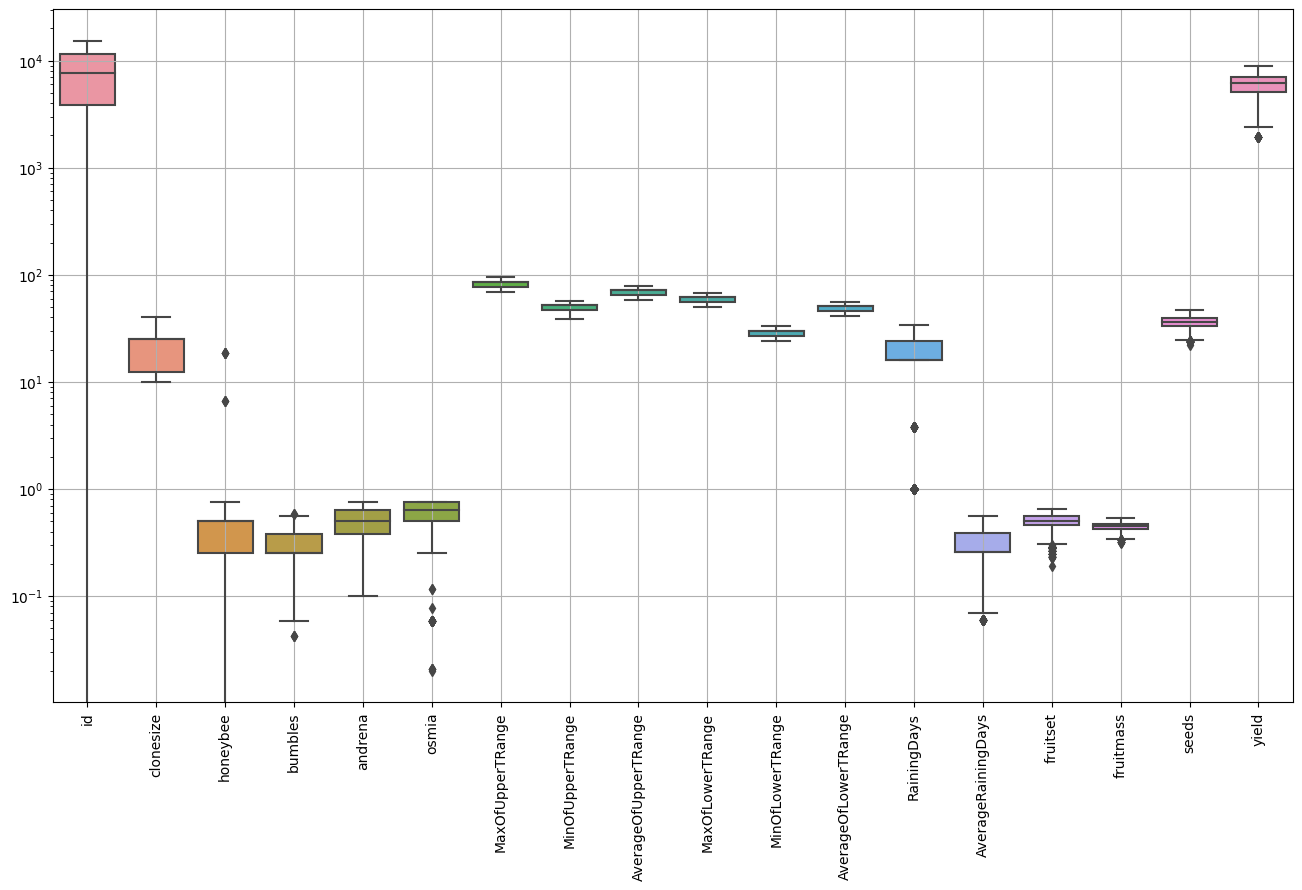

In [16]:
ax = sns.boxplot(data=df_train, orient="v", showfliers=True)
ax.set_yscale("log")
plt.xticks(rotation = 90)
plt.grid(visible=True, which='major', axis='both')

SUMMARY:
- id = redundant column = drop<br>

Chosen to keep all the rest features and use Feature selection methods

# Data preprocessing



Drop redundant column





In [17]:
red_col = ['id']
df_train = df_train.drop(red_col, axis=1)
df_test = df_test.drop(red_col, axis=1)

Drop rows with low yield value in highly correclated columns

Acc. to scatter plots, dropping lowest yield value for columns: fruitset,	fruitmass and	seeds.

In [18]:
df_yield = df_[df_['yield'] < 2100].iloc[:,14:18]
print(f'Rows with yield < 2100 is:{len(df_yield)}')

df_train = df_train.drop(df_train[df_train['yield'] < 2100].index)

Rows with yield < 2100 is:26


Drop duplicates

In [19]:
dups = df_train.duplicated()
print(dups.any())
print(df_train[dups])

df_train = df_train.drop_duplicates(subset=df_train.columns[1:18], keep='first')

True
       clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
3380        25.0      0.50     0.25     0.63   0.63              86.0   
8060        12.5      0.25     0.38     0.50   0.75              77.4   
9219        37.5      0.75     0.25     0.25   0.25              77.4   
11046       25.0      0.50     0.38     0.63   0.50              86.0   
12589       37.5      0.75     0.25     0.25   0.25              86.0   
14187       12.5      0.25     0.25     0.50   0.75              94.6   
14408       12.5      0.25     0.25     0.25   0.75              69.7   

       MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
3380               52.0                  71.9              62.0   
8060               46.8                  64.7              55.8   
9219               46.8                  64.7              55.8   
11046              52.0                  71.9              62.0   
12589              52.0                  71.9              62.0   
14187   

Cleaning dataset

In [20]:
df2_train = df_train.copy()

In [21]:
group_clonesize = df_.groupby(['clonesize', 'type'])['clonesize'].size().unstack()
group_clonesize

type,test,train
clonesize,,
10.0,2.0,4.0
12.5,4412.0,6717.0
20.0,29.0,56.0
25.0,5569.0,8245.0
37.5,182.0,265.0
40.0,NaN,2.0


In [22]:
df2_train = df2_train.drop(df2_train[df2_train['clonesize'].isin([10, 20, 37.5, 40])].index)

In [23]:
group_RD = df_.groupby(['RainingDays', 'type'])['RainingDays'].size().unstack()
group_RD

type,test,train
RainingDays,,
1.00,2438.0,3521.0
3.77,39.0,48.0
16.00,2831.0,4361.0
24.00,2534.0,3837.0
26.00,NaN,1.0
33.00,1.0,NaN
34.00,2351.0,3521.0


In [24]:
df2_train = df2_train.drop(df2_train[df2_train['RainingDays'].isin([3.77, 26])].index)

In [25]:
group_ARD = df_.groupby(['AverageRainingDays', 'type'])['AverageRainingDays'].size().unstack()
group_ARD

type,test,train
AverageRainingDays,,
0.06,39.0,49.0
0.07,NaN,1.0
0.10,2438.0,3520.0
0.14,NaN,1.0
0.25,NaN,1.0
0.26,2831.0,4361.0
0.39,2534.0,3837.0
0.56,2352.0,3519.0


In [26]:
df2_train = df2_train.drop(df2_train[df2_train['AverageRainingDays'].isin([0.06, 0.07, 0.14, 0.25])].index)

In [27]:
group_honeybee = df_.groupby(['honeybee', 'type'])['honeybee'].size().unstack()
group_honeybee

type,test,train
honeybee,,
0.000,7,16
0.250,4830,7285
0.500,5245,7832
0.537,21,38
0.750,85,110
6.640,2,3
18.430,4,5


In [28]:
df2_train = df2_train.drop(df2_train[~df2_train['honeybee'].isin([0.25, 0.5])].index)

In [29]:
group_bumbles = df_.groupby(['bumbles', 'type'])['bumbles'].size().unstack()
group_bumbles

type,test,train
bumbles,,
0.000,5.0,5.0
0.042,4.0,3.0
0.058,1.0,2.0
0.065,1.0,2.0
0.117,26.0,39.0
0.250,7266.0,10856.0
0.260,NaN,1.0
0.293,NaN,2.0
0.380,2890.0,4376.0


In [30]:
df2_train = df2_train.drop(df2_train[~df2_train['bumbles'].isin([0.25, 0.38])].index)

In [31]:
group_andrena = df_.groupby(['andrena', 'type'])['andrena'].size().unstack()
group_andrena

type,test,train
andrena,,
0.000,4.0,8.0
0.101,NaN,1.0
0.147,1.0,2.0
0.229,1.0,4.0
0.234,NaN,1.0
0.235,NaN,1.0
0.240,NaN,1.0
0.250,1097.0,1624.0
0.260,1.0,NaN


In [32]:
df2_train = df2_train.drop(df2_train[~df2_train['andrena'].isin([0.25, 0.38, 0.5, 0.63, 0.75])].index)

In [33]:
group_osmia = df_.groupby(['osmia', 'type'])['osmia'].size().unstack()
group_osmia

type,test,train
osmia,,
0.000,4.0,6.0
0.020,NaN,1.0
0.021,1.0,4.0
0.033,1.0,NaN
0.058,22.0,42.0
0.060,1.0,NaN
0.078,NaN,1.0
0.101,1.0,NaN
0.117,1.0,2.0


In [34]:
df2_train = df2_train.drop(df2_train[~df2_train['osmia'].isin([0.25, 0.38, 0.5, 0.63, 0.75])].index)

# Model selection

##  Dataset train-test split

In [35]:
# Split-out validation dataset
test_size1 = 0.33
test_size2 = 0.20

train_data = df2_train.drop(['yield','type'], axis=1)
train_target = df2_train['yield']


def split_data(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_data(train_data, train_target, test_size1)
X_train2, X_test2, y_train2, y_test2 = split_data(train_data, train_target, test_size2)

In [36]:
eval33={}
eval20={}

def evaluate_model(models,X_train,y_train):
  # Test options and evaluation metric
  num_folds = 10
  scoring = 'neg_mean_absolute_error'
  evaluation_results={}
  results = []
  names = []
  for name, model in models:
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      # print(msg)
      evaluation_results.update({name: cv_results.mean()})
  return evaluation_results, results

def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

## Evaluate Algorithms: Baseline

In [37]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(tol=0.05)))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(kernel='linear', gamma='auto')))

**Evaluate on plain data**

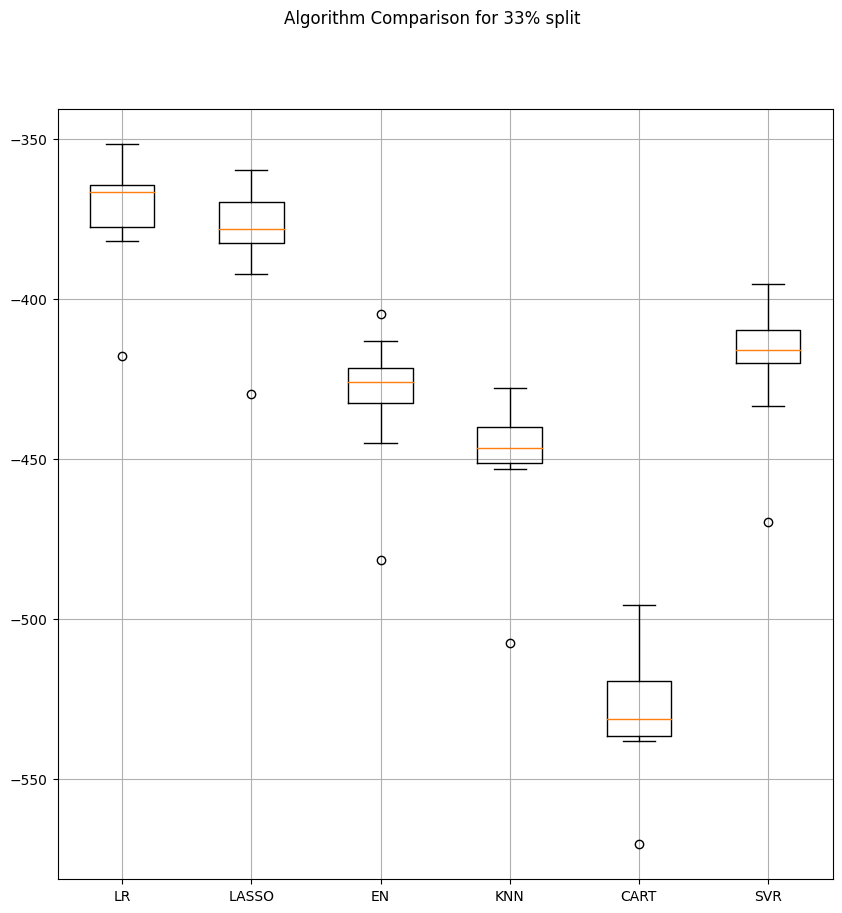

In [38]:
baseline_score1, results1 = evaluate_model(models, X_train, y_train)
eval33 = Merge(eval33, baseline_score1)

# Compare Algorithms Plot
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison for 33% split')
ax = fig.add_subplot(111)
plt.boxplot(results1)
plt.grid()
ax.set_xticklabels(baseline_score1.keys())
plt.show()

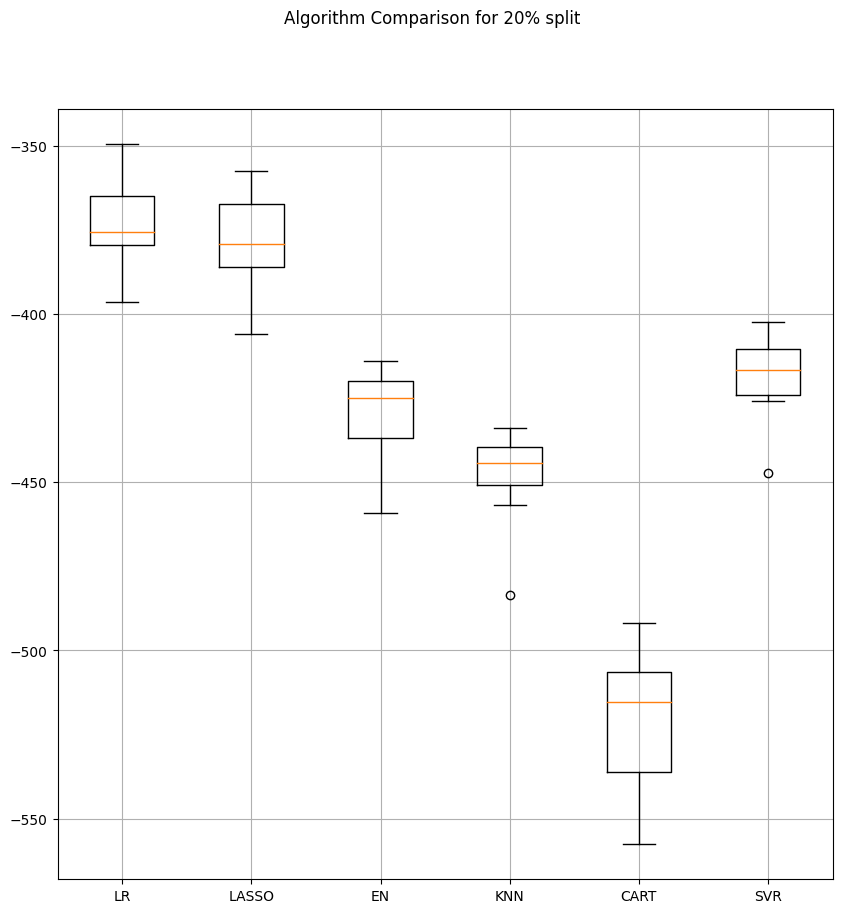

In [39]:
baseline_score2, results2 = evaluate_model(models, X_train2, y_train2)
eval20=Merge(eval20, baseline_score2)

# Compare Algorithms Plot
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison for 20% split')
ax = fig.add_subplot(111)
plt.boxplot(results2)
plt.grid()
ax.set_xticklabels(baseline_score2.keys())
plt.show()

In [40]:
baseline_score1

{'LR': -372.8316300441261,
 'LASSO': -380.9345937756222,
 'EN': -430.2119136524233,
 'KNN': -449.5869426361184,
 'CART': -529.0537215418005,
 'SVR': -419.6632662439003}

In [41]:
baseline_score2

{'LR': -374.12560743079683,
 'LASSO': -377.87564361384227,
 'EN': -429.65348622688737,
 'KNN': -448.12329244907306,
 'CART': -522.0869317718675,
 'SVR': -418.7735123155717}

Baseline best model: LR

## Evaluate Algorithm: PolynomialFeatures

Split 33%

In [42]:
poly33 = PolynomialFeatures(degree=2)

model_poly1 = LinearRegression()

X_train_poly1 = poly33.fit_transform(X_train)
X_test_poly1 = poly33.transform(X_test)

model_poly1.fit(X_train_poly1, y_train)

LinearRegression()

In [43]:
#2nd degree
pred_train = model_poly1.predict(X_train_poly1)
pred_test = model_poly1.predict(X_test_poly1)

Split 20%

In [44]:
poly20 = PolynomialFeatures(degree=2)

model_poly2 = LinearRegression()

X_train_poly2 = poly20.fit_transform(X_train2)
X_test_poly2 = poly20.transform(X_test2)

model_poly2.fit(X_train_poly2, y_train2)

LinearRegression()

In [45]:
#2nd degree
pred_train2 = model_poly2.predict(X_train_poly2)
pred_test2 = model_poly2.predict(X_test_poly2)

In [46]:
def regression_results(y_true, y_pred):
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    return round(mean_absolute_error, 4)

In [47]:
print('Polynomial 33% split: ', regression_results(y_train, pred_train))
print('Polynomial 20% split: ', regression_results(y_train2, pred_train2))

Polynomial 33% split:  -367.6398
Polynomial 20% split:  -363.9349


In [56]:
poly_result = regression_results(y_train, pred_train)*-1
poly_result2 = regression_results(y_train2, pred_train2)*-1

poly={'Poly Feat 33%': poly_result}
poly2={'Poly Feat 20%': poly_result2}

eval33 = Merge(eval33, poly)
eval20 = Merge(eval20, poly2)

Polynomial feature better than LR

## Evaluate Algorithms: Ensemble Methods

Ensemble methods trained on 'plain' data

In [49]:
# ensembles
ensembles = []
ensembles.append(('AB', Pipeline([('AB', AdaBoostRegressor())])))
ensembles.append(('GBM', Pipeline([('GBM', GradientBoostingRegressor())])))
ensembles.append(('RF', Pipeline([('RF', RandomForestRegressor())])))
ensembles.append(('ET', Pipeline([('ET', ExtraTreesRegressor())])))
ensembles.append(('CatB', Pipeline([('CatB', CatBoostRegressor(verbose=False))])))
ensembles.append(('LGBM', Pipeline([('LGMB', LGBMRegressor())])))

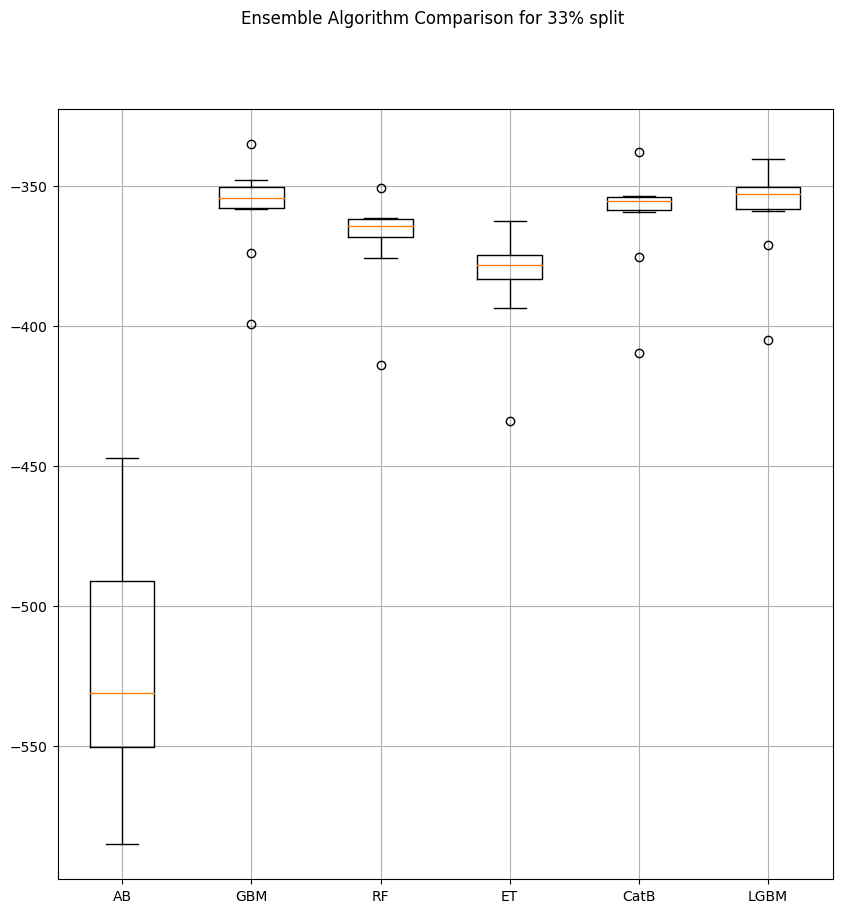

In [50]:
ensembles1 , ens_results1 = evaluate_model(ensembles, X_train, y_train)

# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Ensemble Algorithm Comparison for 33% split')
ax = fig.add_subplot(111)
plt.boxplot(ens_results1)
plt.grid()
ax.set_xticklabels(ensembles1)
plt.show()

In [51]:
eval33 = Merge(eval33, ensembles1)
eval33

{'LR': -372.8316300441261,
 'LASSO': -380.9345937756222,
 'EN': -430.2119136524233,
 'KNN': -449.5869426361184,
 'CART': -529.0537215418005,
 'SVR': -419.6632662439003,
 'Poly Feat 33%': 367.6398,
 'AB': -521.7071282875947,
 'GBM': -358.39451259115776,
 'RF': -369.1756557694756,
 'ET': -383.7635403625122,
 'CatB': -361.2513204544645,
 'LGBM': -358.8251375419015}

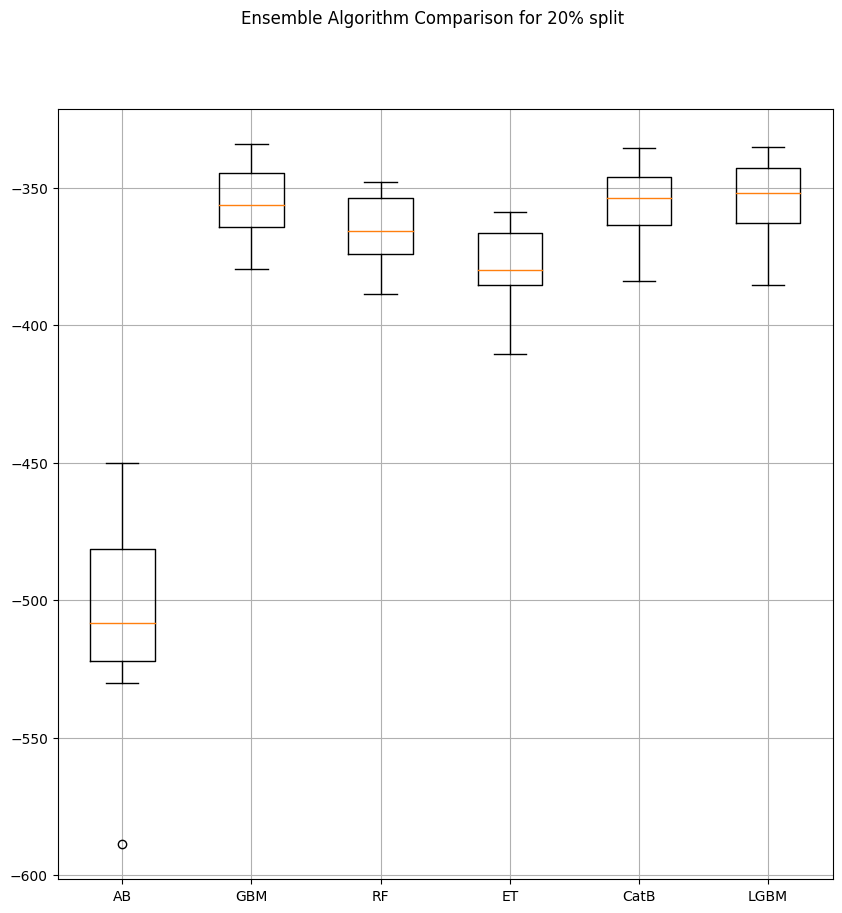

In [52]:
ensembles2 , ens_results2 = evaluate_model(ensembles, X_train2, y_train2)

# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Ensemble Algorithm Comparison for 20% split')
ax = fig.add_subplot(111)
plt.boxplot(ens_results2)
plt.grid()
ax.set_xticklabels(ensembles2)
plt.show()

In [61]:
eval20 = Merge(eval20, ensembles2)
eval20

Improve Results With Tuning

In [54]:
param_grid = {
    'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'n_estimators':[20,50,100,200,300],
    'learning_rate':[0.01, 0.05, 0.75, 0.1, 0.2],
    'max_depth':[2,3,5,7,10],
    'random_state':[42],
    }

model = LGBMRegressor()
kfold = KFold(n_splits=10)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best for 0.33 split: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best for 0.33 split: -357.679525 using {'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'loss': 'absolute_error', 'learning_rate': 0.05}


In [55]:
grid2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_mean_absolute_error', cv=kfold)
grid_result2 = grid2.fit(X_train2, y_train2)
print("Best for 0.20 split: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))

Best for 0.20 split: -353.787229 using {'random_state': 42, 'n_estimators': 300, 'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.05}


## Summary

In [77]:
keys = list(eval33.keys())
values = list(eval33.values())
values_abs = []
for value in values:
  values_abs.append(abs(value))
sorted_value_index = np.argsort(values_abs)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
 
top_models33 = pd.DataFrame.from_dict(sorted_dict, orient='index',columns=['33%_split_size'])

keys2 = list(eval20.keys())
values2 = list(eval20.values())
values_abs2 = []
for value in values2:
  values_abs2.append(abs(value))
sorted_value_index2 = np.argsort(values_abs2)
sorted_dict2 = {keys[i]: values2[i] for i in sorted_value_index2}
 
top_models20 = pd.DataFrame.from_dict(sorted_dict2, orient='index',columns=['20%_split_size'])


eval = top_models20.join(top_models33)
eval

,20%_split_size,33%_split_size
LGBM,-354.357798,-358.825138
GBM,-355.207638,-358.394513
CatB,-355.403283,-361.251320
Poly Feat 33%,-363.934900,-367.639800
RF,-364.958521,-369.175656
LR,-374.125607,-372.831630
LASSO,-377.875644,-380.934594
ET,-379.062302,-383.763540
SVR,-418.773512,-419.663266
EN,-429.653486,-430.211914


Chosen LGBM for final model

# Feature selection - check

In [78]:
# f_regression feature selection 
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=f_regression, k='all')
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs


# mutual feature selection
def select_features_mutual(X_train, y_train, X_test):
  fs_mut = SelectKBest(score_func=mutual_info_regression, k='all')
  fs_mut.fit(X_train, y_train)
  X_train_fs_mut = fs.transform(X_train)
  X_test_fs_mut = fs.transform(X_test)
  return X_train_fs_mut, X_test_fs_mut, fs_mut


def select_best_number_of_feature(model, score_f, X, y):
  # define the evaluation method
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
  # define the pipeline to evaluate
  model_to_pipe = model
  fs = SelectKBest(score_func=score_f)
  pipeline = Pipeline(steps=[('sel',fs), ('lgbm', model_to_pipe)])
  # define the grid
  grid = dict()
  grid['sel__k'] = [i for i in range(1, X.shape[1]+1)]
  # define the grid search
  search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
  # perform the search
  results = search.fit(X, y)
  # summarize best
  print('Best MAE: %.3f' % results.best_score_)
  print('Best Config: %s' % results.best_params_)
  # summarize all
  means = results.cv_results_['mean_test_score']
  params = results.cv_results_['params']
  for mean, param in zip(means, params):
    print('>%.3f with: %r' % (mean, param))

## F_regression method

In [79]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train , X_test)

# what are scores for the features
fs_df = pd.concat([
    pd.DataFrame(X_train.columns, columns=['feature']),
    pd.DataFrame(fs.scores_, columns=['fs_score'])], axis=1).sort_values(by='fs_score', ascending=False)

fig = px.bar(fs_df.sort_values(by='fs_score'), x='fs_score', y='feature',
             height=600, width=800, 
             title='Feature importances for f_regression metod')

fig.show()

In [101]:
select_best_number_of_feature(LGBMRegressor(), f_regression, train_data, train_target)

Best MAE: -350.478
Best Config: {'sel__k': 16}
>-385.483 with: {'sel__k': 1}
>-358.705 with: {'sel__k': 2}
>-353.011 with: {'sel__k': 3}
>-352.838 with: {'sel__k': 4}
>-352.838 with: {'sel__k': 5}
>-352.551 with: {'sel__k': 6}
>-352.554 with: {'sel__k': 7}
>-352.179 with: {'sel__k': 8}
>-352.139 with: {'sel__k': 9}
>-352.640 with: {'sel__k': 10}
>-350.992 with: {'sel__k': 11}
>-350.904 with: {'sel__k': 12}
>-350.891 with: {'sel__k': 13}
>-350.909 with: {'sel__k': 14}
>-350.909 with: {'sel__k': 15}
>-350.478 with: {'sel__k': 16}


## Mutual_info_regression method

In [86]:
# mutual feature selection
X_train_fs_mut, X_test_fs_mut, fs_mut = select_features_mutual(X_train, y_train , X_test)

# what are scores for the features
fs_mut_df = pd.concat([
    pd.DataFrame(X_train.columns, columns=['feature']),
    pd.DataFrame(fs_mut.scores_, columns=['fs_score'])], axis=1).sort_values(by='fs_score', ascending=False)

fig = px.bar(fs_mut_df.sort_values(by='fs_score'), x='fs_score', y='feature',
             height=600, width=800, 
             title='Feature importances for Mutual info Regression metod')

fig.show()

In [88]:
select_best_number_of_feature(LGBMRegressor(), mutual_info_regression, train_data, train_target)

Best MAE: -350.028
Best Config: {'sel__k': 10}
>-385.483 with: {'sel__k': 1}
>-358.705 with: {'sel__k': 2}
>-353.011 with: {'sel__k': 3}
>-352.838 with: {'sel__k': 4}
>-352.838 with: {'sel__k': 5}
>-352.551 with: {'sel__k': 6}
>-352.554 with: {'sel__k': 7}
>-350.991 with: {'sel__k': 8}
>-350.390 with: {'sel__k': 9}
>-350.028 with: {'sel__k': 10}
>-350.414 with: {'sel__k': 11}
>-350.044 with: {'sel__k': 12}
>-350.482 with: {'sel__k': 13}
>-350.236 with: {'sel__k': 14}
>-350.859 with: {'sel__k': 15}
>-350.478 with: {'sel__k': 16}


In [96]:
mir = list(fs_mut_df.feature.iloc[0:10,])
print(mir)

['fruitset', 'seeds', 'fruitmass', 'AverageRainingDays', 'RainingDays', 'clonesize', 'honeybee', 'andrena', 'osmia', 'bumbles']


## RFECV

In [99]:
min_features_to_select = 1  # Minimum number of features to consider
estimator = LGBMRegressor()
cv_rfecv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# create pipeline
rfecv = RFECV(
      estimator=estimator,
      step=1,
      cv=cv_rfecv,
      scoring="neg_mean_absolute_error",
      min_features_to_select=min_features_to_select,
      n_jobs=-1,
  )
rfecv.fit(train_data, train_target)

rfecv = list(train_data.columns[rfecv.support_])
rfecv

['clonesize',
 'bumbles',
 'andrena',
 'osmia',
 'MaxOfUpperTRange',
 'RainingDays',
 'fruitset',
 'fruitmass',
 'seeds']

# Model evaluation

In [106]:
# Test options and evaluation metric
num_folds = 10
scoring = 'neg_mean_absolute_error'
final_results={}
results = []
names = []

In [117]:
def evaluate(model, X_train, X_val, y_train, y_val):
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  MAE_train = round(mean_absolute_error(y_train, y_train_pred),4)
  y_val_pred = model.predict(X_val)
  MAE_val = round(mean_absolute_error(y_val, y_val_pred),4)
  results = pd.DataFrame({'TRAIN': [MAE_train], 'VAL': [MAE_val]})
  return results

## F_reg eval

In [119]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
X_train_fs2, X_test_fs2, fs2 = select_features(X_train2, y_train2, X_test2)

# prepare the model
# scaler = StandardScaler().fit(X_train_fs)
# rescaledX = scaler.transform(X_train_fs)

# model = AdaBoostRegressor(n_estimators=400)
model = LGBMRegressor(**grid_result.best_params_)
model2 = LGBMRegressor(**grid_result2.best_params_)

# model.fit(rescaledX, y_train)
model.fit(X_train_fs, y_train)
model2.fit(X_train_fs2, y_train2)

# evaluate the model
yhat = model.predict(X_test_fs)
yhat2 = model2.predict(X_test_fs2)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
mae2 = mean_absolute_error(y_test2, yhat2)
print('MAE split 0.33: %.3f' % mae)
print('MAE split 0.20: %.3f' % mae2)

MAE split 0.33: 342.712
MAE split 0.20: 342.292


OPTUNA

In [123]:
def objective_f_reg(trial):
    params = {
        'metric': 'mae',      
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42,
        'verbose': -1}

    model = LGBMRegressor(**params)
    cv_result = cross_val_score(model, cv=5, X=X_train_fs, y=y_train, scoring='neg_mean_absolute_error')
    score = -cv_result.mean()    
    return score


sampler = optuna.samplers.TPESampler(seed=42)
study_f_reg = optuna.create_study(direction='minimize', sampler=sampler)
study_f_reg.optimize(objective_f_reg, n_trials=100, show_progress_bar=True)

params_f_reg = study_f_reg.best_params
model_f_reg = LGBMRegressor(**params_f_reg, random_state=42)

result_f_reg_split33 =  evaluate(model_f_reg, X_train_fs, X_test_fs, y_train, y_test)
result_f_reg_split33

[I 2023-05-31 21:00:30,744] A new study created in memory with name: no-name-3aefc2e8-6dcd-478b-98d5-74ceef5ba0b1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 21:00:53,991] Trial 0 finished with value: 419.7956251124032 and parameters: {'max_depth': 6, 'n_estimators': 954, 'learning_rate': 0.2198661886016101, 'num_leaves': 315, 'min_child_samples': 19, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.5290418060840998}. Best is trial 0 with value: 419.7956251124032.
[I 2023-05-31 21:01:00,699] Trial 1 finished with value: 400.0637044090056 and parameters: {'max_depth': 11, 'n_estimators': 621, 'learning_rate': 0.2127137007610176, 'num_leaves': 30, 'min_child_samples': 98, 'colsample_bytree': 0.9162213204002109, 'subsample': 0.6061695553391381}. Best is trial 1 with value: 400.0637044090056.
[I 2023-05-31 21:01:01,579] Trial 2 finished with value: 362.3476158710502 and parameters: {'max_depth': 4, 'n_estimators': 224, 'learning_rate': 0.09196843064490177, 'num_leaves': 278, 'min_child_samples': 46, 'colsample_bytree': 0.645614570099021, 'subsample': 0.8059264473611898}. Best is trial 2 with value: 362.3476158710502.
[I 2023

TypeError: ignored

In [125]:
def objective_f_reg2(trial):
    params = {
        'metric': 'mae',      
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42,
        'verbose': -1}

    model = LGBMRegressor(**params)
    cv_result = cross_val_score(model, cv=5, X=X_train_fs2, y=y_train2, scoring='neg_mean_absolute_error')
    score = -cv_result.mean()    
    return score


sampler = optuna.samplers.TPESampler(seed=42)
study_f_reg2 = optuna.create_study(direction='minimize', sampler=sampler)
study_f_reg2.optimize(objective_f_reg2, n_trials=100, show_progress_bar=True)

params_f_reg2 = study_f_reg2.best_params
model_f_reg2 = LGBMRegressor(**params_f_reg2, random_state=42)

result_f_reg_split20 =  evaluate(model_f_reg2, X_train_fs2, X_test_fs2, y_train2, y_test2)
result_f_reg_split20

[I 2023-05-31 21:06:48,511] A new study created in memory with name: no-name-2592cb1c-f43f-4b37-bebc-66de16a1a52d


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 21:06:54,587] Trial 0 finished with value: 408.14036839178294 and parameters: {'max_depth': 6, 'n_estimators': 954, 'learning_rate': 0.2198661886016101, 'num_leaves': 315, 'min_child_samples': 19, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.5290418060840998}. Best is trial 0 with value: 408.14036839178294.
[I 2023-05-31 21:07:01,625] Trial 1 finished with value: 392.94332041792256 and parameters: {'max_depth': 11, 'n_estimators': 621, 'learning_rate': 0.2127137007610176, 'num_leaves': 30, 'min_child_samples': 98, 'colsample_bytree': 0.9162213204002109, 'subsample': 0.6061695553391381}. Best is trial 1 with value: 392.94332041792256.
[I 2023-05-31 21:07:02,651] Trial 2 finished with value: 358.2549360827311 and parameters: {'max_depth': 4, 'n_estimators': 224, 'learning_rate': 0.09196843064490177, 'num_leaves': 278, 'min_child_samples': 46, 'colsample_bytree': 0.645614570099021, 'subsample': 0.8059264473611898}. Best is trial 2 with value: 358.2549360827311.
[I 

,TRAIN,VAL
0,333.1045,341.5063


## Mutual info reg eval

In [129]:
# feature selection
X_train_fs_mut, X_test_fs_mut, fs_mut = select_features_mutual(X_train, y_train, X_test)
X_train_fs_mut2, X_test_fs_mut2, fs_mut2 = select_features_mutual(X_train2, y_train2, X_test2)
# fit the model
model_mir = LGBMRegressor(**grid_result.best_params_)
model_mir2 = LGBMRegressor(**grid_result2.best_params_)

model_mir.fit(X_train_fs_mut, y_train)
model_mir2.fit(X_train_fs_mut2, y_train2)

# evaluate the model
yhat_mir = model_mir.predict(X_test_fs_mut)
yhat_mir2 = model_mir2.predict(X_test_fs_mut2)
# evaluate predictions
mae_mir = mean_absolute_error(y_test, yhat_mir)
mae_mir2 = mean_absolute_error(y_test2, yhat_mir2)
print('MAE 0.33 split: %.3f' % mae_mir)
print('MAE 0.20 split: %.3f' % mae_mir2)

MAE 0.33 split: 342.712
MAE 0.20 split: 342.292


OPTUNA

In [130]:
def objective_mir(trial):
    params = {
        'metric': 'mae',      
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42,
        'verbose': -1}

    model = LGBMRegressor(**params)
    cv_result = cross_val_score(model, cv=5, X=X_train_fs_mut, y=y_train, scoring='neg_mean_absolute_error')
    score = -cv_result.mean()    
    return score


sampler = optuna.samplers.TPESampler(seed=42)
study_mir = optuna.create_study(direction='minimize', sampler=sampler)
study_mir.optimize(objective_mir, n_trials=100, show_progress_bar=True)

params_mir = study_mir.best_params
model_mir = LGBMRegressor(**params_mir, random_state=42)

result_mir_split33 =  evaluate(model_mir, X_train_fs, X_test_fs, y_train, y_test)
result_mir_split33

[I 2023-05-31 21:29:27,138] A new study created in memory with name: no-name-0bc02584-59e9-4f37-a7f6-9bced4898cf9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 21:29:49,980] Trial 0 finished with value: 419.7956251124032 and parameters: {'max_depth': 6, 'n_estimators': 954, 'learning_rate': 0.2198661886016101, 'num_leaves': 315, 'min_child_samples': 19, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.5290418060840998}. Best is trial 0 with value: 419.7956251124032.
[I 2023-05-31 21:30:00,207] Trial 1 finished with value: 400.0637044090056 and parameters: {'max_depth': 11, 'n_estimators': 621, 'learning_rate': 0.2127137007610176, 'num_leaves': 30, 'min_child_samples': 98, 'colsample_bytree': 0.9162213204002109, 'subsample': 0.6061695553391381}. Best is trial 1 with value: 400.0637044090056.
[I 2023-05-31 21:30:01,110] Trial 2 finished with value: 362.3476158710502 and parameters: {'max_depth': 4, 'n_estimators': 224, 'learning_rate': 0.09196843064490177, 'num_leaves': 278, 'min_child_samples': 46, 'colsample_bytree': 0.645614570099021, 'subsample': 0.8059264473611898}. Best is trial 2 with value: 362.3476158710502.
[I 2023

,TRAIN,VAL
0,340.9727,341.5577


In [131]:
def objective_mir2(trial):
    params = {
        'metric': 'mae',      
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42,
        'verbose': -1}

    model = LGBMRegressor(**params)
    cv_result = cross_val_score(model, cv=5, X=X_train_fs_mut, y=y_train, scoring='neg_mean_absolute_error')
    score = -cv_result.mean()    
    return score


sampler = optuna.samplers.TPESampler(seed=42)
study_mir2 = optuna.create_study(direction='minimize', sampler=sampler)
study_mir2.optimize(objective_mir2, n_trials=100, show_progress_bar=True)

params_mir2 = study_mir2.best_params
model_mir2 = LGBMRegressor(**params_mir2, random_state=42)

result_mir_split20 =  evaluate(model_mir2, X_train_fs_mut2, X_test_fs_mut2, y_train2, y_test2)
result_mir_split20

[I 2023-05-31 21:33:21,983] A new study created in memory with name: no-name-81a14e7c-5719-4c7a-a76a-429260e40de8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 21:33:30,252] Trial 0 finished with value: 419.7956251124032 and parameters: {'max_depth': 6, 'n_estimators': 954, 'learning_rate': 0.2198661886016101, 'num_leaves': 315, 'min_child_samples': 19, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.5290418060840998}. Best is trial 0 with value: 419.7956251124032.
[I 2023-05-31 21:33:34,382] Trial 1 finished with value: 400.0637044090056 and parameters: {'max_depth': 11, 'n_estimators': 621, 'learning_rate': 0.2127137007610176, 'num_leaves': 30, 'min_child_samples': 98, 'colsample_bytree': 0.9162213204002109, 'subsample': 0.6061695553391381}. Best is trial 1 with value: 400.0637044090056.
[I 2023-05-31 21:33:35,321] Trial 2 finished with value: 362.3476158710502 and parameters: {'max_depth': 4, 'n_estimators': 224, 'learning_rate': 0.09196843064490177, 'num_leaves': 278, 'min_child_samples': 46, 'colsample_bytree': 0.645614570099021, 'subsample': 0.8059264473611898}. Best is trial 2 with value: 362.3476158710502.
[I 2023

,TRAIN,VAL
0,339.9958,341.5787


## RFECV evaluation

In [ ]:
model_rfecv = LGBMRegressor(**grid_result.best_params_)
cv_rfecv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
pipeline = Pipeline(steps=[('s',rfecv),('m',model_rfecv)])

# evaluate model
n_scores= cross_val_score(pipeline, train_data[rfecv], train_target, scoring='neg_mean_absolute_error', cv=cv_rfecv)
# report performance
print('MAE: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

OPTUNA

In [138]:
def objective_rfecv(trial):
    params = {'metric': 'mae',      
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 6,
        'verbose': -1}

    optuna_model = LGBMRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X_train[rfecv], y=y_train,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()    
    return score


sampler = optuna.samplers.TPESampler(seed=42)
study_rfecv = optuna.create_study(direction='minimize', sampler=sampler)
study_rfecv.optimize(objective_rfecv, n_trials=100, show_progress_bar=True)

params_rfecv = study_rfecv.best_params
model_rfecv = LGBMRegressor(**params_rfecv, random_state=42)

result_rfecv_split33 =  evaluate(model_rfecv, X_train[rfecv], X_test[rfecv], y_train, y_test)
result_rfecv_split33

[I 2023-05-31 21:45:03,205] A new study created in memory with name: no-name-cddf68d9-d0d0-4664-a29b-24d1d2ce6864


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 21:45:09,447] Trial 0 finished with value: 417.65124016035645 and parameters: {'max_depth': 6, 'n_estimators': 954, 'learning_rate': 0.2198661886016101, 'num_leaves': 315, 'min_child_samples': 19, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.5290418060840998}. Best is trial 0 with value: 417.65124016035645.
[I 2023-05-31 21:45:19,425] Trial 1 finished with value: 401.9376534003187 and parameters: {'max_depth': 11, 'n_estimators': 621, 'learning_rate': 0.2127137007610176, 'num_leaves': 30, 'min_child_samples': 98, 'colsample_bytree': 0.9162213204002109, 'subsample': 0.6061695553391381}. Best is trial 1 with value: 401.9376534003187.
[I 2023-05-31 21:45:25,055] Trial 2 finished with value: 361.8766583241806 and parameters: {'max_depth': 4, 'n_estimators': 224, 'learning_rate': 0.09196843064490177, 'num_leaves': 278, 'min_child_samples': 46, 'colsample_bytree': 0.645614570099021, 'subsample': 0.8059264473611898}. Best is trial 2 with value: 361.8766583241806.
[I 20

,TRAIN,VAL
0,338.6314,341.6102


In [140]:
def objective_rfecv2(trial):
    params = {'metric': 'mae',      
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 6,
        'verbose': -1}

    optuna_model = LGBMRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X_train2[rfecv], y=y_train2,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()    
    return score


sampler = optuna.samplers.TPESampler(seed=42)
study_rfecv2 = optuna.create_study(direction='minimize', sampler=sampler)
study_rfecv2.optimize(objective_rfecv2, n_trials=100, show_progress_bar=True)

params_rfecv2 = study_rfecv2.best_params
model_rfecv2 = LGBMRegressor(**params_rfecv2, random_state=42)

result_rfecv_split20 =  evaluate(model_rfecv2, X_train2[rfecv], X_test2[rfecv], y_train2, y_test2)
result_rfecv_split20

[I 2023-05-31 21:54:48,021] A new study created in memory with name: no-name-f3048394-9f63-427e-b2fd-14538f2d3cb4


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 21:54:55,569] Trial 0 finished with value: 409.1433371806926 and parameters: {'max_depth': 6, 'n_estimators': 954, 'learning_rate': 0.2198661886016101, 'num_leaves': 315, 'min_child_samples': 19, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.5290418060840998}. Best is trial 0 with value: 409.1433371806926.
[I 2023-05-31 21:54:59,313] Trial 1 finished with value: 392.68024240720746 and parameters: {'max_depth': 11, 'n_estimators': 621, 'learning_rate': 0.2127137007610176, 'num_leaves': 30, 'min_child_samples': 98, 'colsample_bytree': 0.9162213204002109, 'subsample': 0.6061695553391381}. Best is trial 1 with value: 392.68024240720746.
[I 2023-05-31 21:55:00,157] Trial 2 finished with value: 357.8651178623795 and parameters: {'max_depth': 4, 'n_estimators': 224, 'learning_rate': 0.09196843064490177, 'num_leaves': 278, 'min_child_samples': 46, 'colsample_bytree': 0.645614570099021, 'subsample': 0.8059264473611898}. Best is trial 2 with value: 357.8651178623795.
[I 20

,TRAIN,VAL
0,326.6345,341.245


# CONTINUE HERE

# SUMMARY

In [141]:
#Summary for LGBMRegressor
result_LGBM = pd.concat([mae, mae2, result_f_reg_split33, result_f_reg_split20, mae_mir, mae_mir2, result_mir_split33, result_mir_split20, result_rfecv_split33, result_rfecv_split20], keys=['f_reg', 'mur_info_reg', 'rfecv'])
result_LGBM

TypeError: ignored

Predictions

In [ ]:
X_test = df_test[mir or rfecv?]
X_test.sample(5)

,fruitset,seeds,fruitmass,AverageRainingDays,clonesize,honeybee,osmia,bumbles,andrena,MaxOfLowerTRange
1482,0.478469,34.260034,0.421840,0.39,25.0,0.50,0.63,0.38,0.38,50.2
6910,0.444254,33.449385,0.423013,0.56,12.5,0.25,0.50,0.25,0.38,62.0
4214,0.538704,37.782288,0.446451,0.39,25.0,0.50,0.63,0.38,0.38,50.2
9747,0.603525,42.485953,0.506002,0.26,12.5,0.25,0.63,0.25,0.63,62.0
5368,0.586304,40.265408,0.483356,0.39,12.5,0.25,0.25,0.25,0.25,68.2


In [ ]:
best_model = XXXXX

In [ ]:
X = X_train[mir or rfecv?]
y = y_train

In [ ]:
best_model.fit(X, y)

LGBMRegressor(colsample_bytree=0.8031824234491852,
              learning_rate=0.037154612713091395, max_depth=5,
              min_child_samples=8, n_estimators=176, num_leaves=350,
              random_state=6, subsample=0.9194623359512195)

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_pred

array([4258.47455328, 6117.18063082, 7198.74628155, ..., 6563.4095475 ,
       4412.12569836, 7267.19727398])